Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip should cut the data size by a large amount, as the number of trips is just:
${n \choose 2} $. 

In [15]:
from feature_utils import load_hdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = {"path":"data/","taxi":"taxi.h5", "rideshare":"tnp_test.h5" }

In [148]:
rideshare = load_hdf(data["path"]+data["rideshare"],100)

In [149]:
rideshare.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,Final_Fare,l2_dist_km,x_dist_km,y_dist_km,bearing,bAirport,day_of_wk,hour
6283605,1913.0,6.7,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,17.50,7.881464,4.808806,6.242793,-142.361378,False,5,0
10327851,1335.0,5.4,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,15.00,5.462890,1.120689,5.346614,168.152913,False,1,8
581229,1560.0,5.3,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,10.67,6.649193,2.368313,6.212725,-159.115063,False,6,14
10148217,590.0,5.9,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,12.50,4.664751,2.201044,4.113162,-28.136520,False,1,22
1776825,1126.0,4.8,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,5.00,4.316367,2.606686,3.440859,-37.129196,False,3,15


In [150]:
orig_names = ["Pickup_Centroid_Latitude", "Dropoff_Centroid_Latitude",
              "Pickup_Centroid_Longitude","Dropoff_Centroid_Longitude"]

locs = ["latp","latd","longp","longd"]

rideshare.rename(index=str, columns={a:b for a,b in zip(orig_names, locs)}, inplace=True)


for coord in locs:
    print(rideshare[coord].nunique())


873
875
872
874


So there are about 900 unique lat/longs giving ~ 500k trip combinations.

In [104]:
# total distinct rides:
900**2/2

405000.0

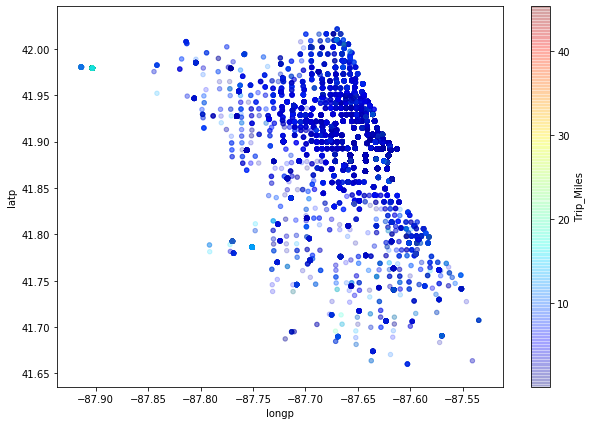

In [65]:
rideshare.plot(kind = "Scatter", x = "longp", y = "latp", alpha = 0.2, figsize = (10,7),
            c = "Trip_Miles", cmap = plt.get_cmap('jet'),colorbar = True, sharex=False
)

#### Grouping by rides:

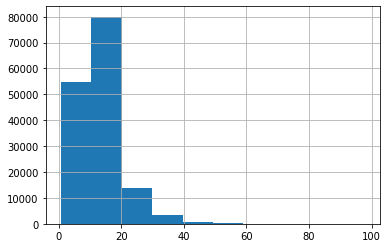

In [132]:
rideshare.groupby(["latp","longd"]).Final_Fare.mean().hist()

In [151]:
def find_boundary(df, padding = 0.001):
    topleft = (max(df.latp.max(),df.latd.max())+padding,min(df.longp.min(),df.longd.min())-padding)
    bottomright = (min(df.latp.min(),df.latd.min())-padding,max(df.longp.max(),df.longd.max())+padding)
    return topleft, bottomright

def coord_bins(df, n = 100):
    """Generate the grid from the lat and long."""
    topleft, bottomright = find_boundary(df)
    lat_axis = np.linspace(bottomright[0],topleft[0],n)
    long_axis = np.linspace(topleft[1],bottomright[1],n)
    return lat_axis, long_axis


def cut_along_lat_long(df, locs, n_bins = 100):
    labels = np.arange(n_bins-1)
    mapping = {loc:loc + "_b" for loc in locs}
    lat_axis, long_axis = coord_bins(df, n_bins)
    
    for lat in locs[0:2]:
        df[mapping[lat]] = pd.cut(rideshare[lat], bins = lat_axis,labels = labels, retbins=False)

    for long in locs[2:]:
        df[mapping[long]] = pd.cut(rideshare[long], bins = long_axis,labels = labels, retbins=False)
        
    df['path'] = list(zip(zip(df.latp_b,df.longp_b), zip(df.latd_b,df.longd_b)))

    

41.6502216756

In [258]:
#bins = pd.interval_range(start=41, end=42, periods = 100)

cut_along_lat_long(rideshare, locs, n_bins = 30)

In [202]:
rideshare.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,latp,longp,latd,longd,vel_mph,...,y_dist_km,bearing,bAirport,day_of_wk,hour,latp_b,latd_b,longp_b,longd_b,path
6283605,1913.0,6.7,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,...,6.242793,-142.361378,False,5,0,44,36,33,25,"((44, 33), (36, 25))"
10327851,1335.0,5.4,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,...,5.346614,168.152913,False,1,8,36,30,34,35,"((36, 34), (30, 35))"
581229,1560.0,5.3,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,...,6.212725,-159.115063,False,6,14,37,30,34,30,"((37, 34), (30, 30))"
10148217,590.0,5.9,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,...,4.113162,-28.136520,False,1,22,11,16,37,34,"((11, 37), (16, 34))"
1776825,1126.0,4.8,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,...,3.440859,-37.129196,False,3,15,38,42,32,28,"((38, 32), (42, 28))"


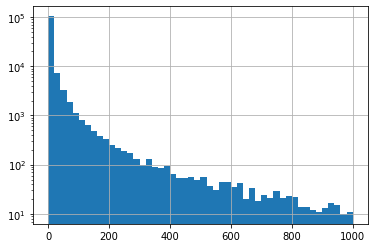

In [254]:
rideshare.groupby('path').Final_Fare.count().hist(bins = 50, range = (0,1000),log = True)

Prints the number of unique trips at this binsize
150k is about the max for the tnp_test data, we know the max possible based on the input data binning
s 400k. We need some balance of bin size between having enough data to show the user a histogram and accuracy.

issue: trip miles has somewhat significant deviation from each other even with fine binning... shared rides?

In [259]:
rideshare.groupby('path').Trip_Miles.count().count()

43692

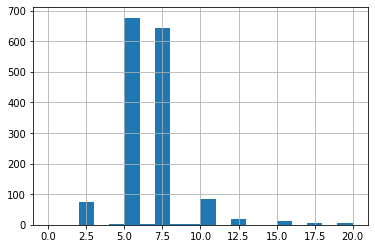

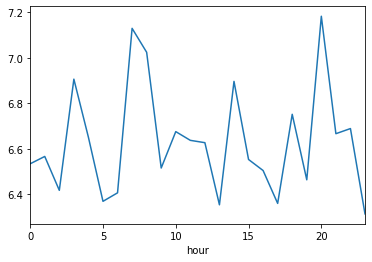

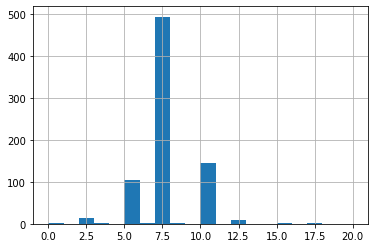

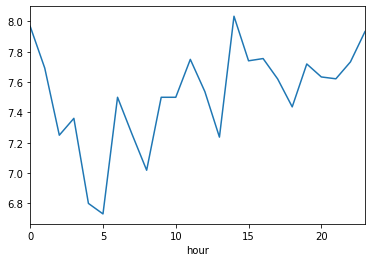

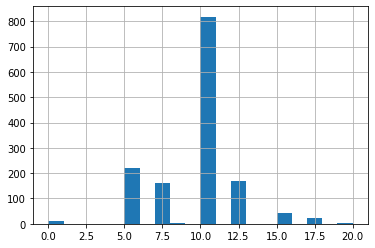

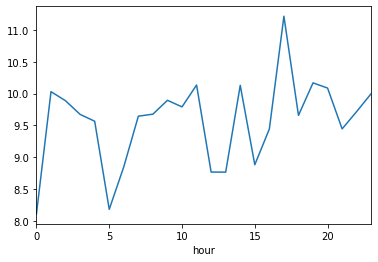

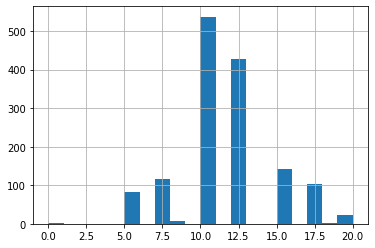

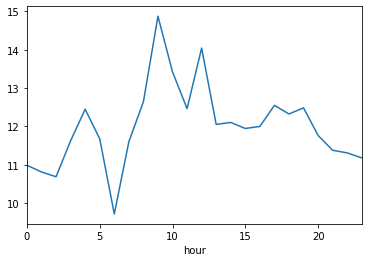

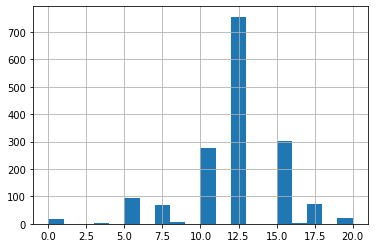

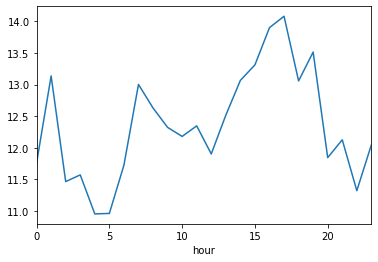

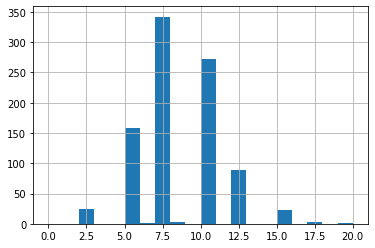

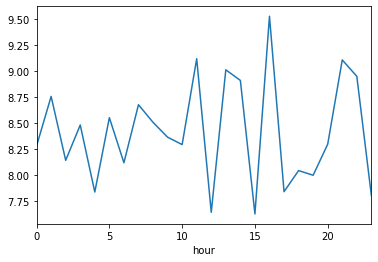

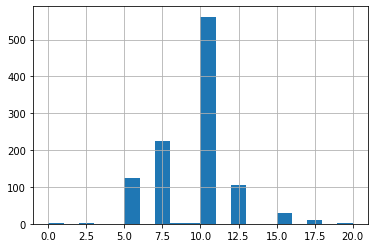

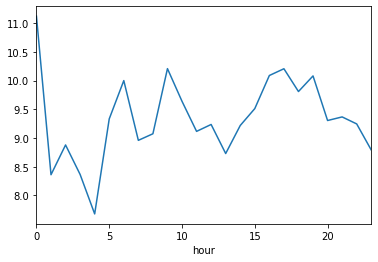

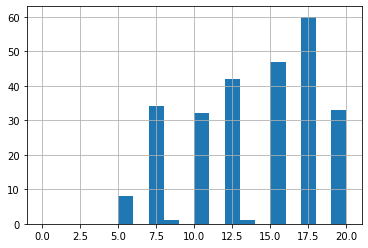

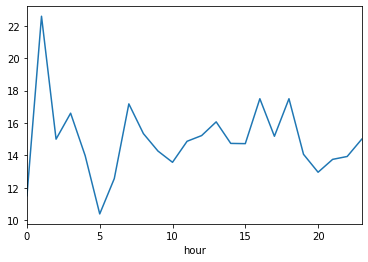

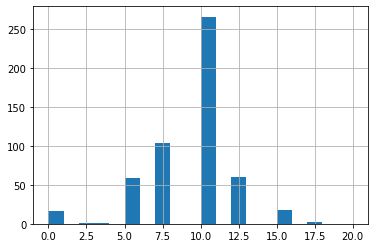

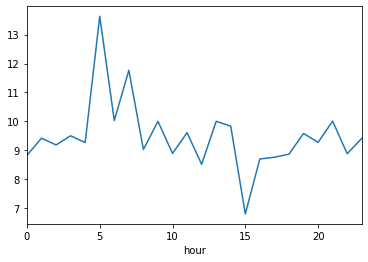

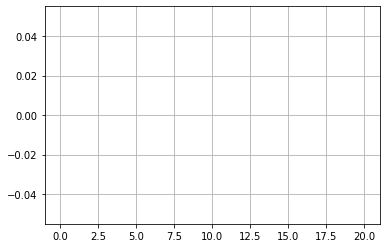

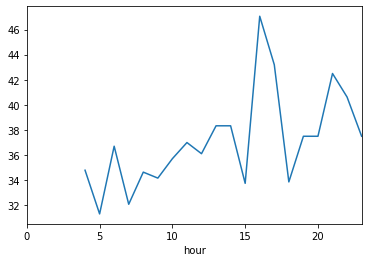

In [262]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),10)]['path'].values

for test_path in test_paths:
    rideshare[rideshare.path == test_path].Final_Fare.hist(bins = 20, range = (0,20))
    plt.show()
    rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.mean().plot()
    plt.show()
    

TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

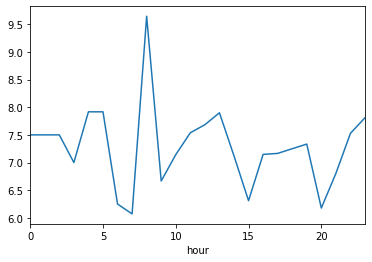

In [250]:
test_path = test_paths[0]
rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.mean().plot()

In [209]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),10)]['path'].values

In [214]:
test_paths

array([((31, 36), (32, 36)), ((33, 25), (35, 27)), ((31, 32), (26, 36)),
       ((30, 37), (31, 36)), ((32, 35), (31, 36)), ((30, 36), (35, 33)),
       ((27, 37), (24, 33)), ((30, 37), (31, 35)), ((34, 35), (24, 33)),
       ((31, 36), (39, 34))], dtype=object)